In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### 1. 그래프 상태 정의

In [131]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langchain.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_nomic.embeddings import NomicEmbeddings
from langgraph.graph import START, END, StateGraph
from typing_extensions import TypedDict, List
from bs4 import BeautifulSoup
import requests
import uuid
import json
from IPython.display import Image, display
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.llms import OpenAI
from langchain.chains import LLMChain
from langchain_community.vectorstores import SKLearnVectorStore
from transformers import pipeline
import re

# Define the GraphState class
class GraphState(TypedDict):
    question: str
    documents: List[str]
    cleaned_text: str
    steps: List[str]

### 3. 노드 함수 정의

In [133]:
# 구글에서 문서를 검색하는 노드
def search_google(state):
    question = state["question"]
    search = GoogleSerperAPIWrapper(gl="kr", hl="ko", k=10)
    results = search.results(question)

    # Print the results for debugging
    #print("Search Results:", results)

    # Extract links from the 'organic' search results
    documents = [result["link"] for result in results.get("organic", [])]
    steps = state["steps"]
    steps.append("search_google")
    return {"documents": documents, "question": question, "steps": steps}


# 문서의 본문을 가져오는 노드
def fetch_documents(state):
    documents = state["documents"]
    fetched_docs = []
    for url in documents:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        paragraphs = soup.find_all("p")
        text = " ".join([p.get_text() for p in paragraphs])
        fetched_docs.append(text)
    steps = state["steps"]
    steps.append("fetch_documents")
    return {"documents": fetched_docs, "question": state["question"], "steps": steps}


# 문서를 정리하는 노드
def clean_documents(state):
    documents = state["documents"]
    combined_text = " ".join(documents)

    # 키워드를 파일명으로 사용
    keyword = state["question"]
    sanitized_keyword = re.sub(
        r'[\\/*?:"<>|]', "", keyword
    )  # 파일명에 사용할 수 없는 문자 제거
    filename = f"{sanitized_keyword}_original_text.txt"

    # 요약하기 전의 텍스트를 파일에 저장
    with open(filename, "w", encoding="utf-8") as file:
        file.write(combined_text)

    # 문장을 분리
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
    sentences = text_splitter.split_text(combined_text)

    # 요약을 위한 프롬프트 템플릿 생성
    prompt_template = PromptTemplate(
        input_variables=["text"],
        template="키워드는 {keyword} 입니다. 다음 텍스트에서 키워드와 직접적으로 관련 있는 내용만 발췌해 주세요. \n\n{text}",
    )

    # LLMChain 생성
    # llm = ChatOllama(
    #     model="llama3.1",
    #     temperature=0)
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    summarization_chain = LLMChain(llm=llm, prompt=prompt_template)

    # 문서 요약 생성
    summaries = []
    for sentence in sentences:
        summary = summarization_chain.run(text=sentence, keyword=keyword)
        summaries.append(summary)

    cleaned_text = " ".join(summaries)
    steps = state["steps"]
    steps.append("clean_documents")
    return {"cleaned_text": cleaned_text, "question": state["question"], "steps": steps}


# 텍스트 파일로 저장하는 노드
def save_to_file(state):
    cleaned_text = state["cleaned_text"]

    # 키워드를 파일명으로 사용
    keyword = state["question"]
    sanitized_keyword = re.sub(
        r'[\\/*?:"<>|]', "", keyword
    )  # 파일명에 사용할 수 없는 문자 제거
    filename = f"{sanitized_keyword}_research_result.txt"

    with open(filename, "w", encoding="utf-8") as file:
        file.write(cleaned_text)
        
    steps = state["steps"]
    steps.append("save_to_file")
    return {"cleaned_text": cleaned_text, "question": state["question"], "steps": steps}

### 3. 그래프 정의 및 빌드

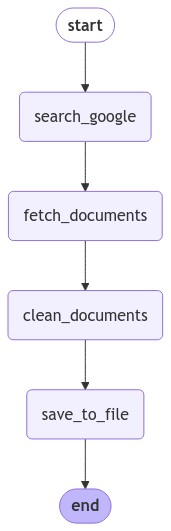

In [134]:
# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("search_google", search_google)  # Google search
workflow.add_node("fetch_documents", fetch_documents)  # Fetch documents
workflow.add_node("clean_documents", clean_documents)  # Clean documents
workflow.add_node("save_to_file", save_to_file)  # Save to file

# Build graph
workflow.add_edge(START, "search_google")
workflow.add_edge("search_google", "fetch_documents")
workflow.add_edge("fetch_documents", "clean_documents")
workflow.add_edge("clean_documents", "save_to_file")
workflow.add_edge("save_to_file", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

### 4. 에이전트 실행 함수 정의

In [135]:
def predict_custom_agent_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}

    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )

    # Print the state dictionary for debugging
    #print("State Dictionary:", state_dict)

    return {"response": state_dict["cleaned_text"], "steps": state_dict["steps"]}


example = {"input": "갑자(甲子)"}
response = predict_custom_agent_answer(example)
print(response)

/var/folders/0q/rrv0s8pn0d78fk2pt7fl2r400000gn/T/ipykernel_55792/200000274.py:62: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


{'response': '갑자(甲子)는 60간지 중 1번째이다. \'갑\'은 청이므로 \'파란 쥐의 해\'다. 납음은 해중금(海中金)이다.  \n갑자년(甲子年)은 60갑자 혹은 60간지의 1번째이다. 서력 연도를 60으로 나눠 나머지가 4인 해가 해당된다.  \n갑자일(甲子日)은 일진이 갑자인 날로, 육십간지의 1번째 날이다. 올해가 어떤 해인지 결정짓는 것은 ‘60갑자(甲子)’다. 60갑자(갑자-계해)를 한 생애(生涯)라 하고, 60갑자 첫 번째인 갑자(甲子)는 천간은 갑목(甲木), 지지는 자수(子水)로 되어 있다. 갑자년에 일어난 사건들을 살펴보면, 조선시대 1504년(연산군 10년) 갑자사화가 있다. 연산군의 어머니 폐비 윤씨의 복위 문제로 인하여 일어난 사화로, 연산군이 폐비 윤씨의 복위를 추진하면서 성종 때 폐비를 찬성한 훈구 원로세력이 대부분 숙청을 당했다. 1924년 갑자년에 일본은 조선반도에서 처음으로 징용을 모집해 보국대란 명분으로 나이 18∼19세의 젊은이들이 신체검사 후 군수물자 생산 공장으로 끌려가 일했다. 일명 ‘묻지마 갑자생’이라 불렀다. 갑자를 ‘고목나무 아래 쥐’로도 표현한다. 그러나 ‘춘양목 아래 쥐’가 노는 평화로운 곳이 되기 위해서는 지역의 지식인, 기업인, 언론인 그리고 시민들이 건강한 자유 시민으로서 행동에 동참하여 지역의 낙후된 문화, 예술, 언론 분야에 한 목소리를 내야 한다. 올해가 어떤 해인지 결정짓는 것은 ‘60갑자(甲子)’다. 60갑자 첫 번째인 갑자(甲子)는 천간은 갑목(甲木), 지지는 자수(子水)로 되어 있다. 갑자년에 일어난 사건들을 살펴보면, 조선시대 1504년(연산군 10년) 갑자사화가 있다. 1924년 갑자년에 일본은 조선반도에서 처음으로 징용을 모집해 보국대란 명분으로 나이 18∼19세의 젊은이들이 신체검사 후 군수물자 생산 공장으로 끌려가 일했다. 일명 ‘묻지마 갑자생’이라 불렀다. 주어진 텍스트에서 \'갑자(甲子)\'와 직접적으로 관련된 내용은 포함되어 있지 않습니다. \'갑자\'는 주로 간지(干